# Convergence Analysis

This notebook outlines the main results for the convergence analysis of the Stochastic Gradient Hamiltonian Monte Carlo (SGHMC). For this analysis, we will investigate the stationarity convergence of the SGHMC using the following scenarios:
<table align = "left">
<tr><td>Sample Sizes:</td></tr>
<tr><td></td><td>100</td></tr>
<tr><td></td><td>10000</td></tr>
<tr><td></td><td>100000000</td></tr>
</table>

In [1]:
out_path = joinpath(homedir(), "Dropbox/MS THESIS/R/MAIN RESULTS");

In [3]:
using Distributions: pdf, rand, Uniform, Normal
using DataFrames: DataFrame, nrow, writetable, stack, unstack
using Gadfly
using Mamba
using RDatasets
using StatsBase: autocor

Gadfly.push_theme(:dark)

## 1 Functions
The following imports the MCMC functions needed for later computations.

In [4]:
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/MH.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/HMC.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/SG HMC.jl"));

## 2 Bayesian Linear Regression

In [5]:
# The log likelihood function is given by the following codes:
function loglike(theta::Array{Float64}; alpha::Float64 = alpha, x::Array{Float64} = x, y::Array{Float64} = y)
  yhat = theta[1] + theta[2] * x

  likhood = Float64[]
  for i in 1:length(yhat)
    push!(likhood, pdf(Normal(yhat[i], alpha), y[i]))
  end

  return likhood |> sum
end

# Define the logprior and logposterior
function logprior(theta::Array{Float64}; mu::Array{Float64} = mu, s::Array{Float64} = s)
  w0_prior = log(pdf(Normal(mu[1, 1], s[1, 1]), theta[1]))
  w1_prior = log(pdf(Normal(mu[2, 1], s[2, 2]), theta[2]))
   w_prior = [w0_prior w1_prior]

  return w_prior |> sum
end

function logpost(theta::Array{Float64})
  loglike(theta, alpha = alpha, x = x, y = y) + logprior(theta, mu = mu, s = s)
end

Potential(theta::Array{Float64}) = - logpost(theta)

Kinetic(p::Array{Float64}; Σ = eye(length(p))) = (p' * inv(Σ) * p) / 2

function dPotential(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta
end

function dPotential_noise(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta + randn(2, 1)
end

dKinetic(p::AbstractArray{Float64}; Σ::Array{Float64} = eye(length(p))) = inv(Σ) * p;

<h2 style = "color:orange; font-family:Georgia;">A. Sample Size: 100</h2>

In [6]:
srand(123);
w0 = -.3; w1 = -.5; stdev = 5.;

# Define data parameters
alpha = 1 / stdev; # for likelihood

# Generate Hypothetical Data
n = 100;
x = rand(Uniform(-1, 1), n);
A = [ones(length(x)) x];
B = [w0; w1];
f = A * B;
y = f + rand(Normal(0, alpha), n);

# Define Hyperparameters
Imat = eye(2);
b = 2.; # for prior
b1 = (1 / b)^2; # Square this since in Julia, rnorm uses standard dev

mu = zeros(2); # for prior
s = b1 * Imat; # for prior

xy_df = DataFrame(X = x, Y = y);
burn_in = 1000;

### 2.1 Metropolis-Hasting

In [7]:
mh_object = MH(logpost);
@time chain1 = mcmc(mh_object, r = 10000);

  0.574932 seconds (971.60 k allocations: 109.862 MB, 3.41% gc time)


In [8]:
mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])

1×2 Array{Float64,2}:
 -0.280759  -0.475921

In [9]:
xy_df_mh = xy_df;

In [10]:
xy_df_mh[:Yhat] = mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[1] + mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[2] * xy_df[:X];

In [11]:
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_mh[Symbol("Yhat_Sample_" * string(i))] = chain1[i, 1] + chain1[i, 2] * xy_df_mh[:X]
end

In [12]:
xy_stack_mh = DataFrame(X = repeat(Array(xy_df_mh[:X]), outer = 3000), 
                        Y = repeat(Array(xy_df_mh[:Y]), outer = 3000),
                        Var = Array(stack(xy_df_mh[:, 4:end])[1]),
                        Val = Array(stack(xy_df_mh[:, 4:end])[2]));

In [13]:
ch1cor_df = DataFrame(x = collect(0:1:(length(autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1])) - 1)), 
                      y1 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1]),
                      y2 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 2]));

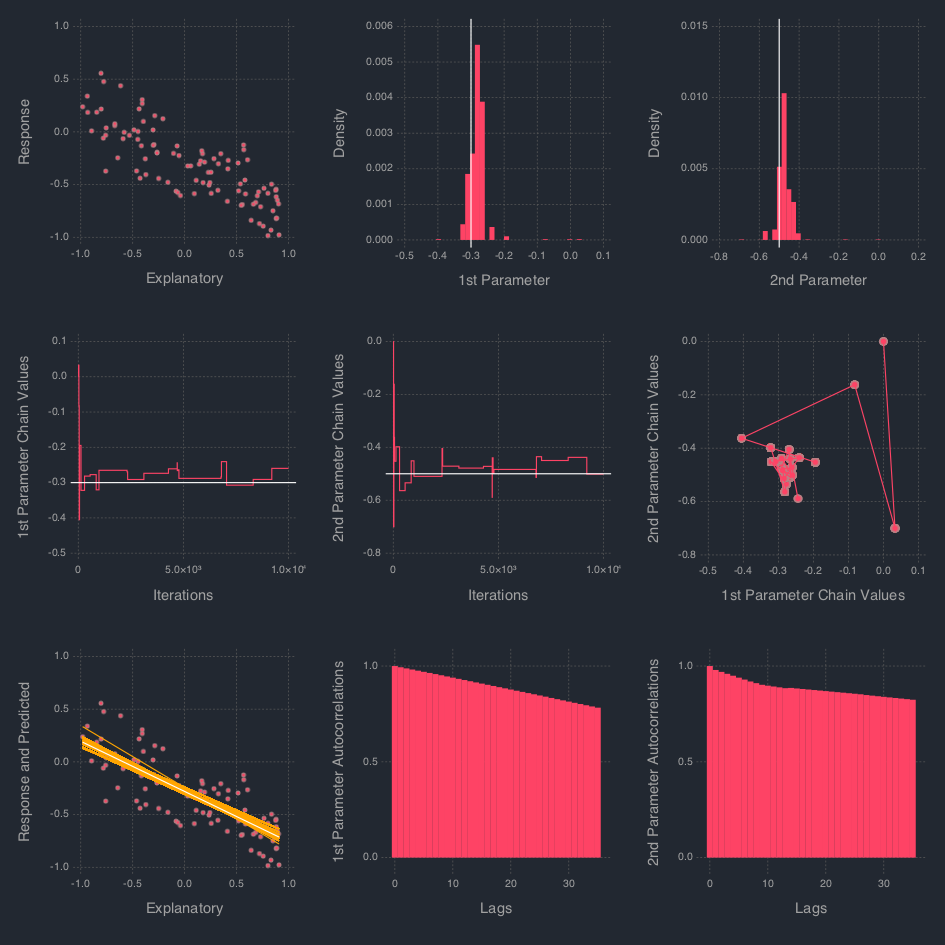

In [14]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain1), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain1), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain1), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_mh, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_mh, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_mh, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch1cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
p8 = plot(ch1cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

#### 2.1.1 Diagnostics

In [17]:
?gelmandiag

search: gelmandiag



No documentation found.

`Mamba.gelmandiag` is a `Function`.

```
# 1 method for generic function "gelmandiag":
gelmandiag(c::Mamba.AbstractChains; alpha, mpsrf, transform) at /Users/al-ahmadgaidasaad/.julia/v0.5/Mamba/src/output/gelmandiag.jl:5
```


### 2.2 Gibbs

### 2.3 Hamiltonian Monte Carlo

In [22]:
hmc_object = HMC(Potential, Kinetic, dPotential, dKinetic, zeros(2, 1), 2);
@time chain3 = mcmc(hmc_object, r = 10000);

  5.014381 seconds (19.89 M allocations: 1.323 GB, 5.46% gc time)


In [23]:
mapslices(mean, chain3, [1])

1×2 Array{Float64,2}:
 -0.361381  -0.312275

In [24]:
xy_df_hmc = xy_df;

In [25]:
xy_df_hmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_hmc[:X];

In [26]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_hmc[Symbol("Yhat_Sample_" * string(i))] = chain3[i, 1] + chain3[i, 2] * xy_df_hmc[:X]
end

In [27]:
xy_stack_hmc = DataFrame(X = repeat(Array(xy_df_hmc[:X]), outer = 3000), 
                         Y = repeat(Array(xy_df_hmc[:Y]), outer = 3000),
                         Var = Array(stack(xy_df_hmc[:, 4:end])[1]),
                         Val = Array(stack(xy_df_hmc[:, 4:end])[2]));

In [28]:
ch3cor_df = DataFrame(x = collect(0:1:(length(autocor(chain3[:, 1])) - 1)), 
                      y1 = autocor(chain3[:, 1]),
                      y2 = autocor(chain3[:, 2]));

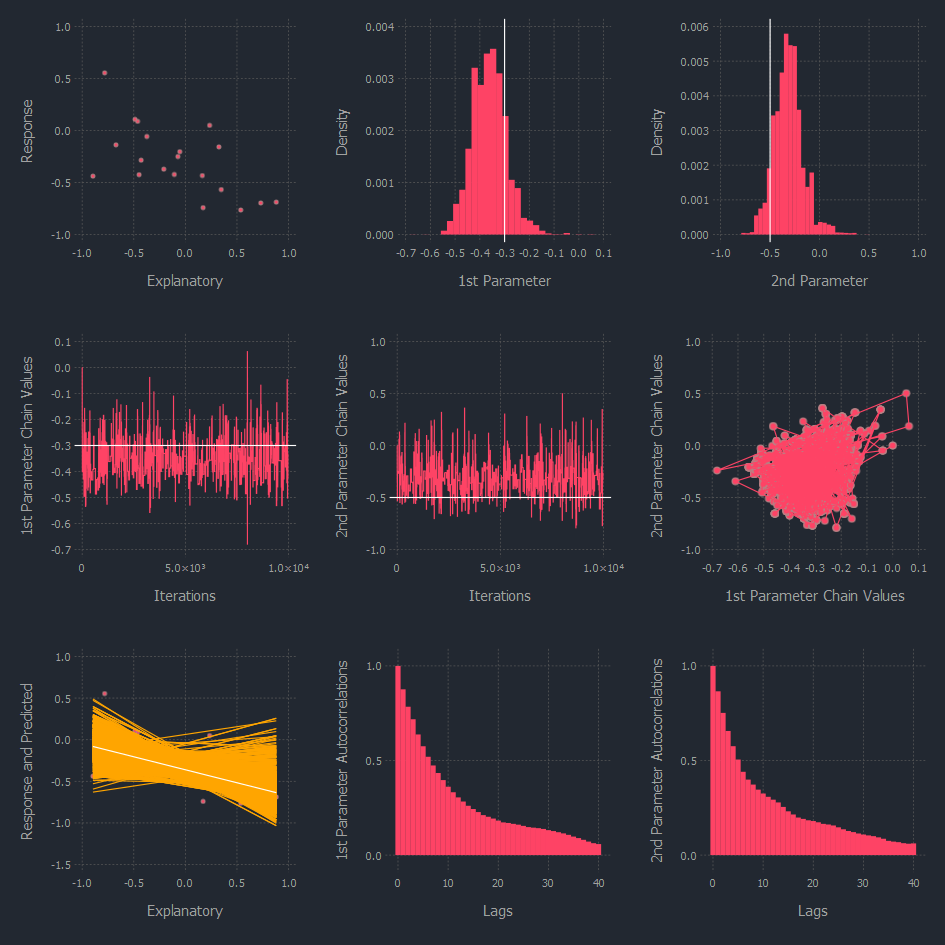

In [29]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain3), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain3), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain3), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_hmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_hmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_hmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch3cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch3cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.4 Stochastic Gradient Hamiltonian Monte Carlo

In [31]:
SGHMC_object = SGHMC(dPotential_noise, dKinetic, eye(2), eye(2), eye(2), [0; 0], 2.);
@time chain4 = mcmc(SGHMC_object, r = 10000)#, leapfrog_params = Dict([:ɛ => .009, :τ => 20]));

  5.865646 seconds (20.67 M allocations: 1.137 GB, 2.94% gc time)


In [32]:
mapslices(mean, chain4, [1])

1×2 Array{Float64,2}:
 -0.198504  -0.126514

In [33]:
xy_df_sghmc = xy_df;

In [34]:
xy_df_sghmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_sghmc[:X];

In [35]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_sghmc[Symbol("Yhat_Sample_" * string(i))] = chain4[i, 1] + chain4[i, 2] * xy_df_sghmc[:X]
end

In [36]:
xy_stack_sghmc = DataFrame(X = repeat(Array(xy_df_sghmc[:X]), outer = 3000), 
                           Y = repeat(Array(xy_df_sghmc[:Y]), outer = 3000),
                           Var = Array(stack(xy_df_sghmc[:, 4:end])[1]),
                           Val = Array(stack(xy_df_sghmc[:, 4:end])[2]));

In [37]:
ch4cor_df = DataFrame(x = collect(0:1:(length(autocor(chain4[:, 1])) - 1)), 
                      y1 = autocor(chain4[:, 1]),
                      y2 = autocor(chain4[:, 2]));

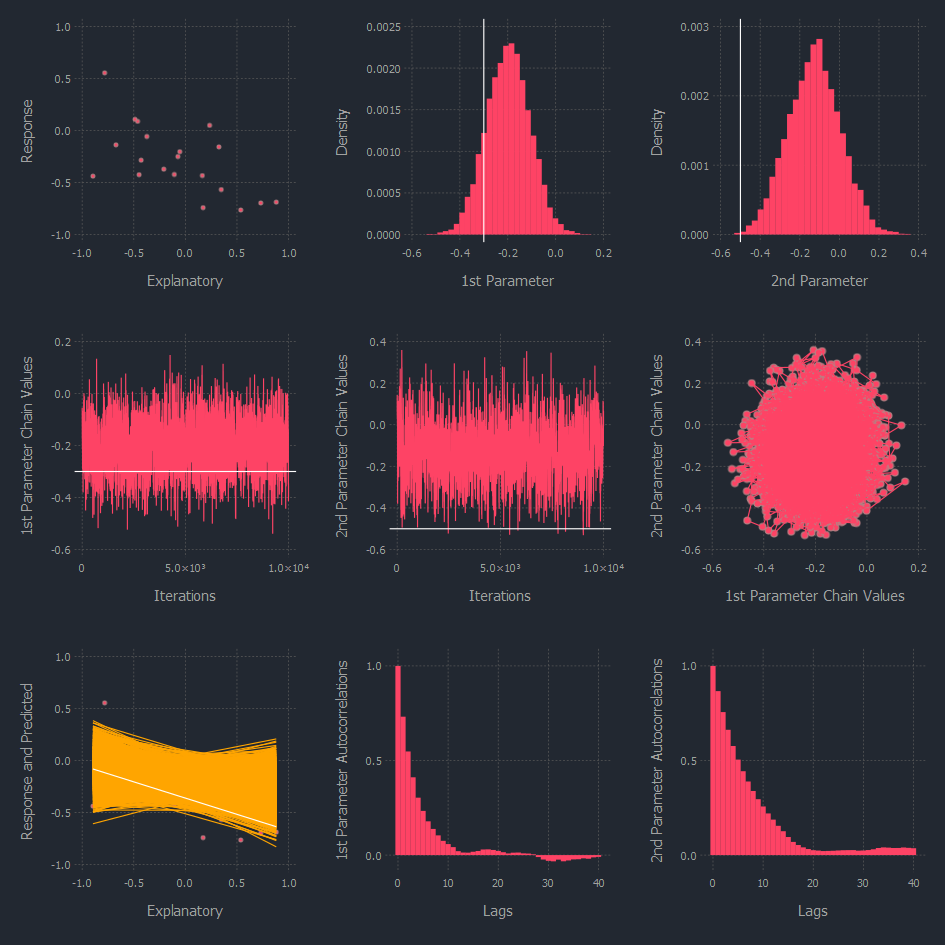

In [38]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain4), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain4), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain4), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_sghmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_sghmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_sghmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch4cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch4cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

<h2 style = "color:orange; font-family:Georgia;">A. Sample Size: 200</h2>

In [39]:
srand(123);
w0 = -.3; w1 = -.5; stdev = 5.;

# Define data parameters
alpha = 1 / stdev; # for likelihood

# Generate Hypothetical Data
n = 200;
x = rand(Uniform(-1, 1), n);
A = [ones(length(x)) x];
B = [w0; w1];
f = A * B;
y = f + rand(Normal(0, alpha), n);

# Define Hyperparameters
Imat = eye(2);
b = 2.; # for prior
b1 = (1 / b)^2; # Square this since in Julia, rnorm uses standard dev

mu = zeros(2); # for prior
s = b1 * Imat; # for prior

xy_df = DataFrame(X = x, Y = y);
burn_in = 1000;

### 2.1 Metropolis-Hasting

In [41]:
mh_object = MH(logpost);
@time chain1 = mcmc(mh_object, r = 10000);

  0.156045 seconds (637.88 k allocations: 169.781 MB, 11.00% gc time)


In [42]:
mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])

1×2 Array{Float64,2}:
 -0.309935  -0.494881

In [43]:
xy_df_mh = xy_df;

In [44]:
xy_df_mh[:Yhat] = mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[1] + mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[2] * xy_df[:X];

In [45]:
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_mh[Symbol("Yhat_Sample_" * string(i))] = chain1[i, 1] + chain1[i, 2] * xy_df_mh[:X]
end

In [46]:
xy_stack_mh = DataFrame(X = repeat(Array(xy_df_mh[:X]), outer = 3000), 
                        Y = repeat(Array(xy_df_mh[:Y]), outer = 3000),
                        Var = Array(stack(xy_df_mh[:, 4:end])[1]),
                        Val = Array(stack(xy_df_mh[:, 4:end])[2]));

In [47]:
ch1cor_df = DataFrame(x = collect(0:1:(length(autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1])) - 1)), 
                      y1 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1]),
                      y2 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 2]));

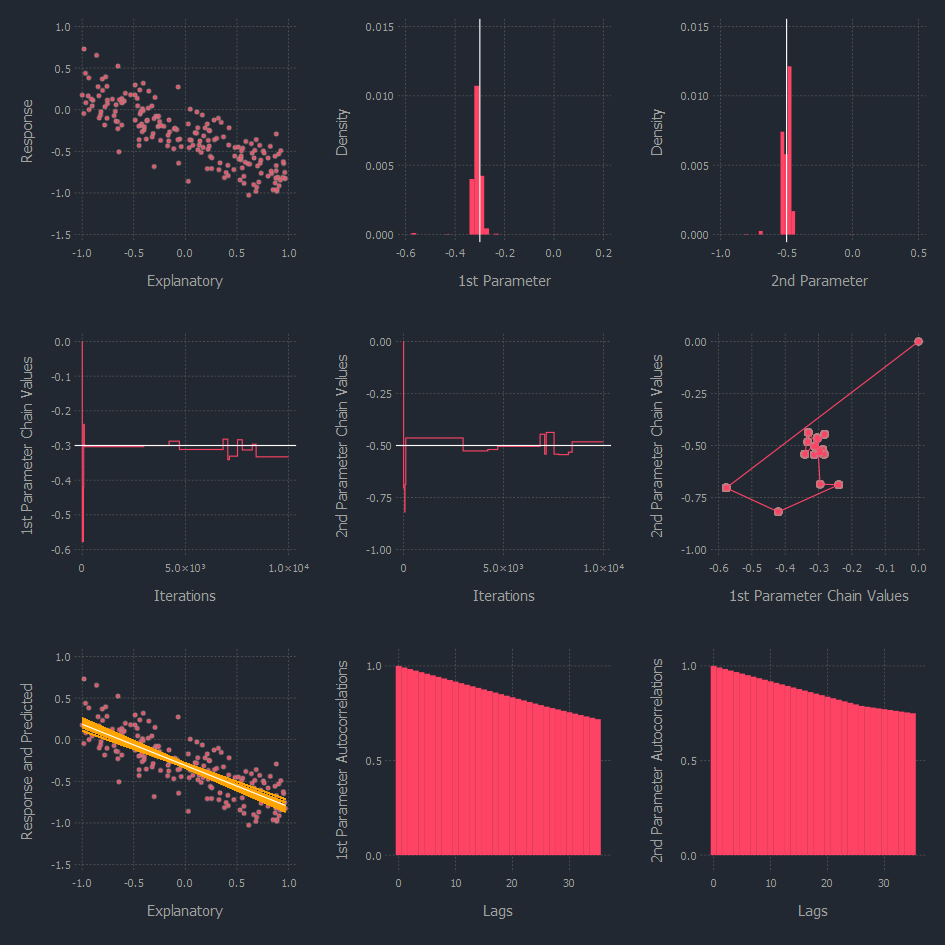

In [48]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain1), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain1), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain1), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_mh, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_mh, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_mh, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch1cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
p8 = plot(ch1cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.2 Gibbs

### 2.3 Hamiltonian Monte Carlo

In [49]:
hmc_object = HMC(Potential, Kinetic, dPotential, dKinetic, zeros(2, 1), 2);
@time chain3 = mcmc(hmc_object, r = 10000);

  5.536165 seconds (18.91 M allocations: 5.499 GB, 10.70% gc time)


In [50]:
mapslices(mean, chain3, [1])

1×2 Array{Float64,2}:
 -0.30741  -0.489496

In [51]:
xy_df_hmc = xy_df;

In [52]:
xy_df_hmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_hmc[:X];

In [53]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_hmc[Symbol("Yhat_Sample_" * string(i))] = chain3[i, 1] + chain3[i, 2] * xy_df_hmc[:X]
end

In [54]:
xy_stack_hmc = DataFrame(X = repeat(Array(xy_df_hmc[:X]), outer = 3000), 
                         Y = repeat(Array(xy_df_hmc[:Y]), outer = 3000),
                         Var = Array(stack(xy_df_hmc[:, 4:end])[1]),
                         Val = Array(stack(xy_df_hmc[:, 4:end])[2]));

In [55]:
ch3cor_df = DataFrame(x = collect(0:1:(length(autocor(chain3[:, 1])) - 1)), 
                      y1 = autocor(chain3[:, 1]),
                      y2 = autocor(chain3[:, 2]));

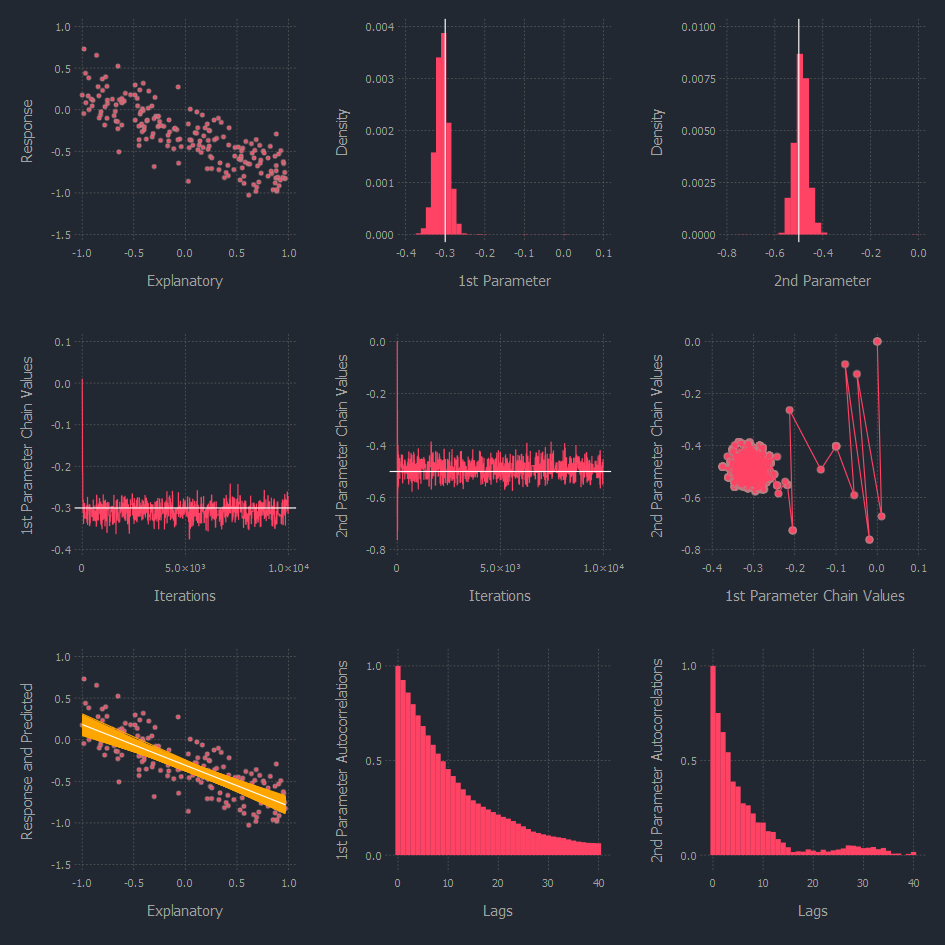

In [56]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain3), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain3), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain3), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_hmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_hmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_hmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch3cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch3cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.4 Stochastic Gradient Hamiltonian Monte Carlo

In [57]:
SGHMC_object = SGHMC(dPotential_noise, dKinetic, eye(2), eye(2), eye(2), [0; 0], 2.);
@time chain4 = mcmc(SGHMC_object, r = 10000)#, leapfrog_params = Dict([:ɛ => .009, :τ => 20]));

  6.353025 seconds (20.49 M allocations: 3.173 GB, 5.48% gc time)


In [58]:
mapslices(mean, chain4, [1])

1×2 Array{Float64,2}:
 -0.28551  -0.451456

In [59]:
xy_df_sghmc = xy_df;

In [60]:
xy_df_sghmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_sghmc[:X];

In [61]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_sghmc[Symbol("Yhat_Sample_" * string(i))] = chain4[i, 1] + chain4[i, 2] * xy_df_sghmc[:X]
end

In [62]:
xy_stack_sghmc = DataFrame(X = repeat(Array(xy_df_sghmc[:X]), outer = 3000), 
                           Y = repeat(Array(xy_df_sghmc[:Y]), outer = 3000),
                           Var = Array(stack(xy_df_sghmc[:, 4:end])[1]),
                           Val = Array(stack(xy_df_sghmc[:, 4:end])[2]));

In [63]:
ch4cor_df = DataFrame(x = collect(0:1:(length(autocor(chain4[:, 1])) - 1)), 
                      y1 = autocor(chain4[:, 1]),
                      y2 = autocor(chain4[:, 2]));

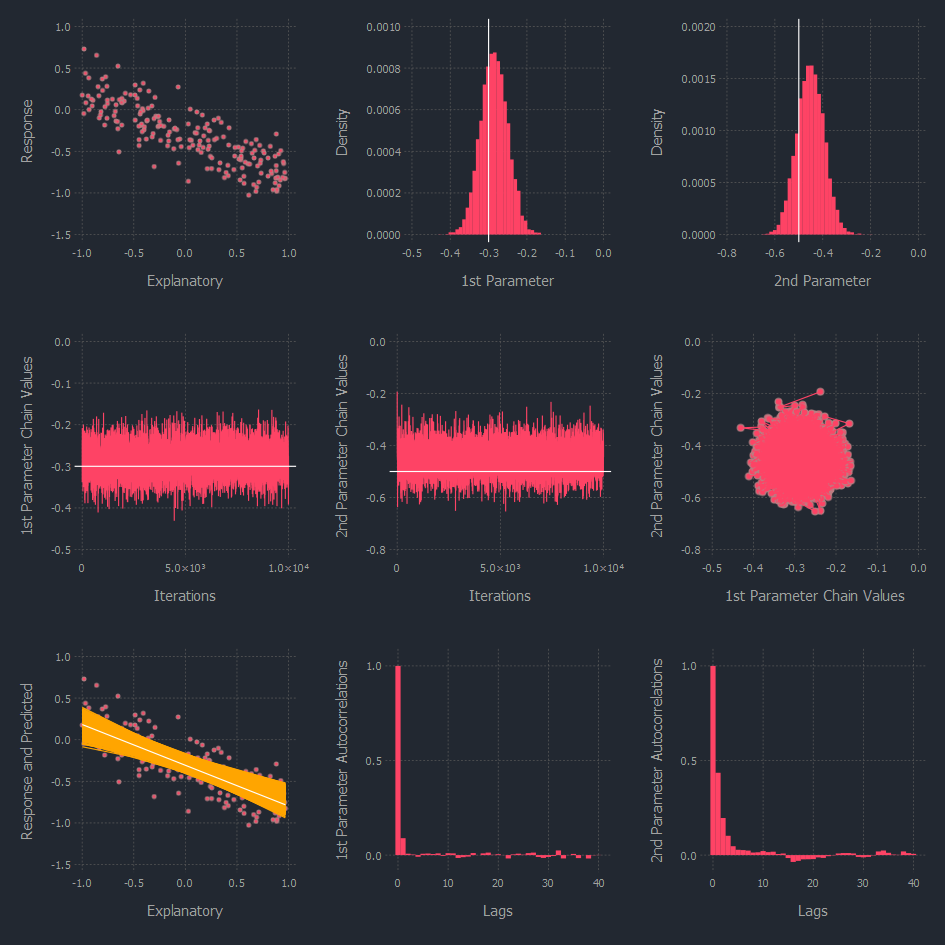

In [64]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain4), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain4), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain4), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_sghmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_sghmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_sghmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch4cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch4cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

<h2 style = "color:orange; font-family:Georgia;">A. Sample Size: 2000</h2>

In [66]:
srand(123);
w0 = -.3; w1 = -.5; stdev = 5.;

# Define data parameters
alpha = 1 / stdev; # for likelihood

# Generate Hypothetical Data
n = 2000;
x = rand(Uniform(-1, 1), n);
A = [ones(length(x)) x];
B = [w0; w1];
f = A * B;
y = f + rand(Normal(0, alpha), n);

# Define Hyperparameters
Imat = eye(2);
b = 2.; # for prior
b1 = (1 / b)^2; # Square this since in Julia, rnorm uses standard dev

mu = zeros(2); # for prior
s = b1 * Imat; # for prior

xy_df = DataFrame(X = x, Y = y);
burn_in = 1000;

### 2.1 Metropolis-Hasting

In [67]:
mh_object = MH(logpost);
@time chain1 = mcmc(mh_object, r = 10000);

  1.204505 seconds (697.89 k allocations: 1.237 GB, 8.75% gc time)


In [68]:
mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])

1×2 Array{Float64,2}:
 -0.304332  -0.527491

In [69]:
xy_df_mh = xy_df;

In [70]:
xy_df_mh[:Yhat] = mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[1] + mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[2] * xy_df[:X];

In [71]:
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_mh[Symbol("Yhat_Sample_" * string(i))] = chain1[i, 1] + chain1[i, 2] * xy_df_mh[:X]
end

In [72]:
xy_stack_mh = DataFrame(X = repeat(Array(xy_df_mh[:X]), outer = 3000), 
                        Y = repeat(Array(xy_df_mh[:Y]), outer = 3000),
                        Var = Array(stack(xy_df_mh[:, 4:end])[1]),
                        Val = Array(stack(xy_df_mh[:, 4:end])[2]));

In [73]:
ch1cor_df = DataFrame(x = collect(0:1:(length(autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1])) - 1)), 
                      y1 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1]),
                      y2 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 2]));

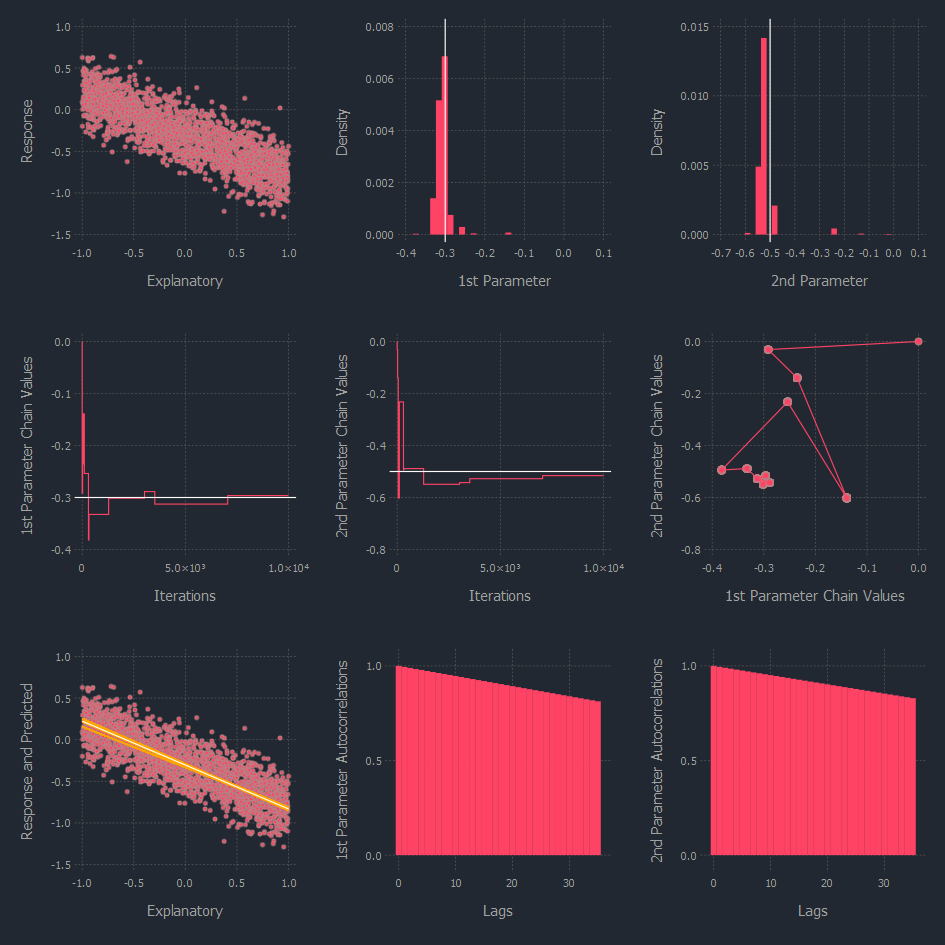

In [74]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain1), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain1), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain1), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_mh, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_mh, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_mh, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch1cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
p8 = plot(ch1cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.2 Gibbs

### 2.3 Hamiltonian Monte Carlo

In [75]:
hmc_object = HMC(Potential, Kinetic, dPotential, dKinetic, zeros(2, 1), 2);
@time chain3 = mcmc(hmc_object, r = 10000);

 14.935996 seconds (18.97 M allocations: 43.909 GB, 17.16% gc time)


In [76]:
mapslices(mean, chain3, [1])

1×2 Array{Float64,2}:
 -0.302384  -0.49917

In [77]:
xy_df_hmc = xy_df;

In [78]:
xy_df_hmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_hmc[:X];

In [79]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_hmc[Symbol("Yhat_Sample_" * string(i))] = chain3[i, 1] + chain3[i, 2] * xy_df_hmc[:X]
end

In [80]:
xy_stack_hmc = DataFrame(X = repeat(Array(xy_df_hmc[:X]), outer = 3000), 
                         Y = repeat(Array(xy_df_hmc[:Y]), outer = 3000),
                         Var = Array(stack(xy_df_hmc[:, 4:end])[1]),
                         Val = Array(stack(xy_df_hmc[:, 4:end])[2]));

In [81]:
ch3cor_df = DataFrame(x = collect(0:1:(length(autocor(chain3[:, 1])) - 1)), 
                      y1 = autocor(chain3[:, 1]),
                      y2 = autocor(chain3[:, 2]));

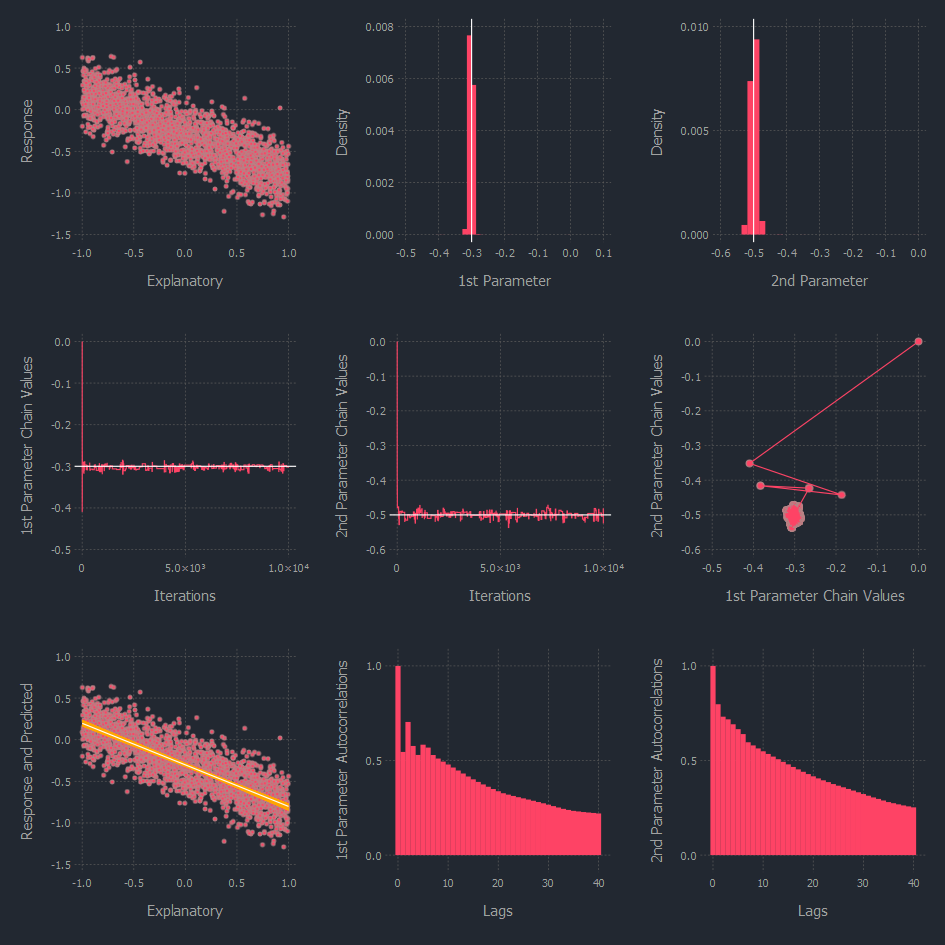

In [82]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain3), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain3), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain3), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_hmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_hmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_hmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch3cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch3cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.4 Stochastic Gradient Hamiltonian Monte Carlo

In [83]:
SGHMC_object = SGHMC(dPotential_noise, dKinetic, eye(2), eye(2), eye(2), [0; 0], 2.);
@time chain4 = mcmc(SGHMC_object, r = 10000)#, leapfrog_params = Dict([:ɛ => .009, :τ => 20]));

 10.397932 seconds (20.49 M allocations: 21.845 GB, 13.52% gc time)


In [84]:
mapslices(mean, chain4, [1])

1×2 Array{Float64,2}:
 -0.300996  -0.495108

In [85]:
xy_df_sghmc = xy_df;

In [86]:
xy_df_sghmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_sghmc[:X];

In [87]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_sghmc[Symbol("Yhat_Sample_" * string(i))] = chain4[i, 1] + chain4[i, 2] * xy_df_sghmc[:X]
end

In [88]:
xy_stack_sghmc = DataFrame(X = repeat(Array(xy_df_sghmc[:X]), outer = 3000), 
                           Y = repeat(Array(xy_df_sghmc[:Y]), outer = 3000),
                           Var = Array(stack(xy_df_sghmc[:, 4:end])[1]),
                           Val = Array(stack(xy_df_sghmc[:, 4:end])[2]));

In [89]:
ch4cor_df = DataFrame(x = collect(0:1:(length(autocor(chain4[:, 1])) - 1)), 
                      y1 = autocor(chain4[:, 1]),
                      y2 = autocor(chain4[:, 2]));

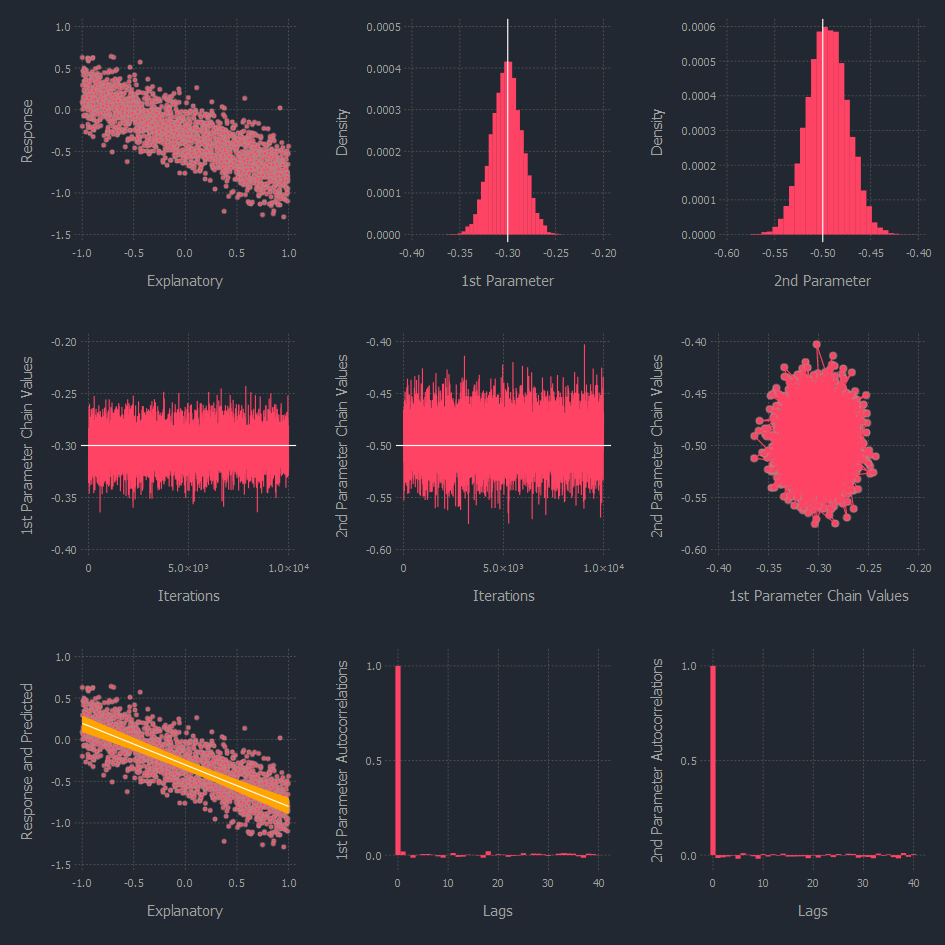

In [90]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain4), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain4), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain4), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_sghmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_sghmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_sghmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch4cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch4cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))